In [ ]:
Cv = 54.17 #clearance volume in cc
a = 5.8 # cm
b = 10.2 # bore length in cm
St = 11.6 # stroke length in cm
l = 23.2 # connecting rod length in cm
pi = 3.14159
R = l/a
gamma_const = 1.38
Pin = 1.995 # bar
Tin = 84+273.15 # Kelvin
c1 = 2.28
c2 = 0.0

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import plotly.graph_objs as go

file_path="data1.csv"

df=pd.read_csv(file_path)

def formula(row):
  return row['CAD']*pi/180

df['CAD in rad']=df.apply(formula,axis=1)

df.to_csv(file_path,index=False)

#instantanoues stroke length
def formula(row):
  return l+a-a*math.cos(row['CAD in rad']) - math.sqrt(pow(l, 2)-pow(a*math.sin(row['CAD in rad']), 2))

df['S'] = df.apply(formula, axis = 1)
df.to_csv(file_path, index = False)

#Volume units in m3
def formula(row):
  return (Cv + (pi*pow(b, 2)*row['S']/4))

df['volume'] = df.apply(formula, axis = 1)
df.to_csv(file_path, index = False)

#pressure
Vin = df['volume'][0]

def formula(row):
  return Pin*pow(Vin, gamma_const)/pow(row['volume'], gamma_const)

df['pressure(bar)'] = df.apply(formula, axis = 1)
df.to_csv(file_path, index = False)

#temperature
def formula(row):
  return Tin*pow(row['volume'], 1-gamma_const) / pow(Vin, 1-gamma_const)

df['temp_var'] = df.apply(formula, axis = 1)
df.to_csv(file_path, index = False)

#gamma
def formula(row):
  return -1.1662*pow(10,-13)*pow(row['temp_var'], 4) + 4.5781*pow(10,-10)*pow(row['temp_var'], 3) - 6.0001*pow(10, -7)*pow(row['temp_var'], 2) + 2.1733*pow(10,-4)*row['temp_var'] + 1.3776

df['gamma_var'] = df.apply(formula, axis = 1)
df.to_csv(file_path, index = False)

#pressure using gamma_var
calculated_values = []
for i in range(1, len(df.axes[0])):
    calculated_value = Pin * pow(Vin, df.at[i, 'gamma_var']) / pow(df.at[i, 'volume'], df.at[i-1, 'gamma_var'])
    calculated_values.append(calculated_value)

calculated_values.insert(0, 1.87)  # Adding the initial value
df['P1'] = calculated_values

#temperature varialble usind gamma variable
df['T1']=Tin*pow(df['volume'], 1-df['gamma_var']) / pow(Vin, 1-df['gamma_var'])

#gamma1
df['gamma1']=-1.1662*pow(10,-13)*pow(df['T1'], 4) + 4.5781*pow(10,-10)*pow(df['T1'], 3) - 6.0001*pow(10, -7)*pow(df['T1'], 2) + 2.1733*pow(10,-4)*df['T1'] + 1.3776

#second iteration
calculated_values = []
for i in range(1, len(df.axes[0])):
    calculated_value = Pin * pow(Vin, df.at[i, 'gamma1']) / pow(df.at[i, 'volume'], df.at[i-1, 'gamma1'])
    calculated_values.append(calculated_value)

calculated_values.insert(0, 1.87)  # Adding the initial value
df['P2'] = calculated_values
df['T2']=Tin*pow(df['volume'], 1-df['gamma1']) / pow(Vin, 1-df['gamma1'])
df['gamma2']=-1.1662*pow(10,-13)*pow(df['T2'], 4) + 4.5781*pow(10,-10)*pow(df['T2'], 3) - 6.0001*pow(10, -7)*pow(df['T2'], 2) + 2.1733*pow(10,-4)*df['T2'] + 1.3776

#Third iteration
calculated_values = []
for i in range(1, len(df.axes[0])):
    calculated_value = Pin * pow(Vin, df.at[i, 'gamma2']) / pow(df.at[i, 'volume'], df.at[i-1, 'gamma2'])
    calculated_values.append(calculated_value)

calculated_values.insert(0, 1.87)  # Adding the initial value
df['P3'] = calculated_values
df['T3']=Tin*pow(df['volume'], 1-df['gamma2']) / pow(Vin, 1-df['gamma2'])

#Pmotor
def formula(row):
  return Pin*pow(Vin, row['gamma2'])/pow(row['volume'], row['gamma2'])

df['Pm'] = df.apply(formula,axis=1)
df.to_csv(file_path, index = False)

#mean piston speed - Sp
def formula(row):
  return 2*St*row['rpm']/6000

df['Sp'] = df.apply(formula, axis = 1)
df.to_csv(file_path, index = False)

# velocity-V
def formula(row):
  return c1*row['Sp'] + c2

df['vel(m/s)'] = df.apply(formula, axis = 1)
df.to_csv(file_path, index = False)

# heat transfer co-efficient [w/m2-K]
A = 130.000 # woschni
const_a = -0.200
const_b = 0.800
const_c = -0.550
const_d = 0.800

def formula(row):
  return A*pow(b/100,const_a)*pow(row['P3'],const_b)*pow(row['T3'],const_c)*pow(row['vel(m/s)'],const_d)
  # return A*pow(b/100,const_a)*pow(row['pressure(bar)']*0.00001,const_b)*pow(row['temp_var'],const_c)*pow(row['vel(m/s)'],const_d)

df['h'] = df.apply(formula, axis = 1)
df.to_csv(file_path, index = False)

# heat transfer co-efficient [w/m2-K]
A = 130.000 # hohenberg
const_a = 0.80
const_b = -0.40
const_c = -0.06
const_d = 0.80

def formula(row):
  return A*pow(row['P3'],const_a)*pow(row['T3'],const_b)*pow(row['volume'],const_c)*pow(row['Sp']+1.4,const_d)
  # return A*pow(b/100,const_a)*pow(row['pressure(bar)']*0.00001,const_b)*pow(row['temp_var'],const_c)*pow(row['vel(m/s)'],const_d)

df['h(hohen)'] = df.apply(formula, axis = 1)
df.to_csv(file_path, index = False)

# Area [m2] formula doubt
A_c = 0 #0.0203 # m2
A_v = 0 #0.0376 # m2

def formula(row):
  return pi*pow(b/100,2) + pi*(b/100)*(St/200)*(R+1 - math.cos(row['CAD in rad']) - math.sqrt(pow(R, 2) - pow(math.sin(row['CAD in rad']), 2))) + A_c + A_v

df['Area'] = df.apply(formula, axis = 1)
df.to_csv(file_path, index = False)

#dtheta

df['d_theta'] = df['CAD in rad'].diff(periods=-1)*-1
df.to_csv(file_path, index = False)

pi = 3.14
df['time'] = (60*df['CAD'])/(2*pi*df['rpm'])

df['dt'] = df['time'].diff(periods=-1)*-1
df.to_csv(file_path, index = False)

# Rate of heat transfer (heat release rate)
Tw = 374.15 # K
pi=3.14

def formula(row):
  return -(row['Area']*row['d_theta']/(6*row['rpm']))*row['h']*(row['T3']-Tw)

df['dQ'] = df.apply(formula, axis = 1)
df.to_csv(file_path, index = False)

# Rate of heat transfer (heat release rate)
def formula(row):
  return -(row['Area']*row['d_theta']/(6*row['rpm']))*row['h(hohen)']*(row['T3']-Tw)

df['dQ(hohen)'] = df.apply(formula, axis = 1)
df.to_csv(file_path, index = False)

#change in volume
df['dV'] = df['volume'].diff(periods=-1)*-1
df.to_csv(file_path, index = False)

#change in pressure (bar)
def formula(row):
  return ((row['dQ']*(row['gamma2']-1))-(row['P3']*row['dV']*row['gamma2']))/row['volume']

df['dP'] = df.apply(formula, axis = 1)
df.to_csv(file_path, index = False)

#change in pressure (bar)
def formula(row):
  return ((row['dQ(hohen)']*(row['gamma2']-1))-(row['P3']*row['dV']*row['gamma2']))/row['volume']

df['dP(hohen)'] = df.apply(formula, axis = 1)
df.to_csv(file_path, index = False)

# Convection pressure
def formula(row):
  return row['dP']+row['P3']

df['P_conv'] = df.apply(formula, axis = 1)
df.to_csv(file_path, index = False)

# Convection pressure
def formula(row):
  return row['dP(hohen)']+row['P3']

df['P_conv(hohen)'] = df.apply(formula, axis = 1)
df.to_csv(file_path, index = False)

# HRR
def formula(row):
  # return row['dQ']*6*row['rpm']/row['d_theta']
   return abs(row['dQ']*6*row['rpm']/row['d_theta'])

df['HRR'] = df.apply(formula, axis = 1)
df.to_csv(file_path, index = False)

df['dV/d0'] = df['volume'].diff(periods=1)/df['CAD'].diff(periods=1)
df['dP/d0'] = df['P3'].diff(periods=1)/df['CAD'].diff(periods=1)
df['dQ/d0'] = (1/(df['gamma2']-1))*df['volume']*df['dP/d0']*-1 + (df['gamma2']/(df['gamma2']-1))*df['P3']*df['dV/d0']*-1

# HRR
def formula(row):
  # return row['dQ']*6*row['rpm']/row['d_theta']
   return abs(row['dQ(hohen)']*6*row['rpm']/row['d_theta'])

df['HRR(hohen)'] = df.apply(formula, axis = 1)
df.to_csv(file_path, index = False)

# Heat flux (kW/m2)
def formula(row):
   return row['h']*(row['T3'] - Tw)/1000

df['Heat_flux'] = df.apply(formula, axis = 1)
df.to_csv(file_path, index = False)

# Heat flux (kW/m2)
def formula(row):
   return row['h(hohen)']*(row['T3'] - Tw)/1000

df['Heat_flux(hohen)'] = df.apply(formula, axis = 1)
df.to_csv(file_path, index = False)

#change in area
df['dA'] = df['Area'].diff(periods=-1)*-1
df.to_csv(file_path, index = False)

R = 8.3144   #--> joules. mole-1. K-1
df['m'] = df['pressure(bar)']*df['volume']/(R*df['T3'])

Cv = R/(gamma_const-1)
df['dT'] = ((-df['pressure(bar)']*df['dV']) - (df['h']*df['dA']/(df['T3']-Tw)))/(df['m']*Cv)
df['dT(hohen)'] = ((-df['P3']*df['dV']) - (df['h(hohen)']*df['dA']/(df['T3']-Tw)))/(df['m']*Cv)

df['T_conv'] = df['dT']+df['T3']
df['T_conv(hohen)'] = df['dT(hohen)']+df['T3']



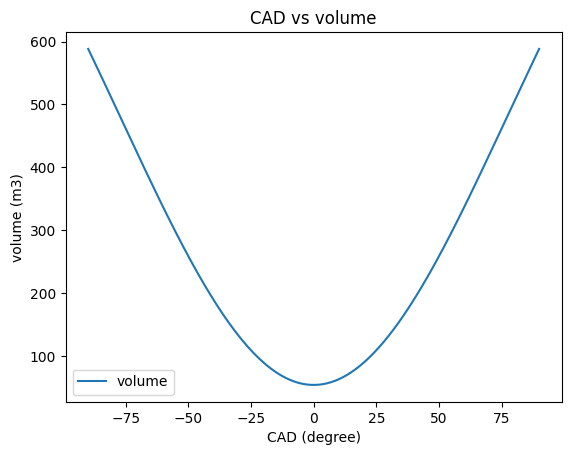

KeyError: ignored

In [ ]:
# form dataframe
data = pd.DataFrame(df, columns=["CAD", "volume"])

# plot the dataframe
data.plot(x="CAD", y=["volume"], kind = "line")
plt.title("CAD vs volume")
plt.xlabel("CAD (degree)")
plt.ylabel("volume (m3)")

# print bar graph
plt.show()

In [ ]:
# form dataframe
data = pd.DataFrame(df, columns=["CAD", "P_conv"])

# plot the dataframe
data.plot(x="CAD", y=["P_conv"], kind = "line")
# plt.xticks(range(300, 380))
plt.title("CAD vs P_conv")
plt.xlabel("CAD (degree)")
plt.ylabel("P_conv (bar)")

# print bar graph
plt.show()

# form dataframe
data = pd.DataFrame(df, columns=["CAD", "P_conv(hohen)"])

# plot the dataframe
data.plot(x="CAD", y=["P_conv(hohen)"], kind = "line")
# plt.xticks(range(300, 380))
plt.title("CAD vs P_conv(hohen)")
plt.xlabel("CAD (degree)")
plt.ylabel("P_conv(hohen) (bar)")

# print bar graph
plt.show()

In [ ]:
# form dataframe
data = pd.DataFrame(df, columns=["CAD", "HRR"])

# plot the dataframe
data.plot(x="CAD", y=["HRR"], kind = "line")
# plt.xticks(range(300, 380))
plt.title("CAD vs HRR")
plt.xlabel("CAD (degree)")
plt.ylabel("HRR")

# print bar graph
plt.show()

# form dataframe
data = pd.DataFrame(df, columns=["CAD", "HRR(hohen)"])

# plot the dataframe
data.plot(x="CAD", y=["HRR(hohen)"], kind = "line")
# plt.xticks(range(300, 380))
plt.title("CAD vs HRR(hohen)")
plt.xlabel("CAD (degree)")
plt.ylabel("HRR(hohen)")

# print bar graph
plt.show()

In [ ]:
# form dataframe
data = pd.DataFrame(df, columns=["CAD", "Heat_flux"])

# plot the dataframe
data.plot(x="CAD", y=["Heat_flux"], kind = "line")
# plt.xticks(range(300, 380))
plt.title("CAD vs Heat_flux")
plt.xlabel("CAD (degree)")
plt.ylabel("Heat_flux")

# print bar graph
plt.show()

# form dataframe
data = pd.DataFrame(df, columns=["CAD", "Heat_flux(hohen)"])

# plot the dataframe
data.plot(x="CAD", y=["Heat_flux(hohen)"], kind = "line")
# plt.xticks(range(300, 380))
plt.title("CAD vs Heat_flux(hohen)")
plt.xlabel("CAD (degree)")
plt.ylabel("Heat_flux(hohen)")

# print bar graph
plt.show()

In [ ]:
# form dataframe
data = pd.DataFrame(df, columns=["CAD", "T_conv"])

# plot the dataframe
data.plot(x="CAD", y=["T_conv"], kind = "line")
plt.title("CAD vs T_conv")
plt.xlabel("CAD (degree)")
plt.ylabel("T_conv")

plt.show()

# form dataframe
data = pd.DataFrame(df, columns=["CAD", "T_conv(hohen)"])

# plot the dataframe
data.plot(x="CAD", y=["T_conv(hohen)"], kind = "line")
plt.title("CAD vs T_conv(hohen)")
plt.xlabel("CAD (degree)")
plt.ylabel("T_conv")

plt.show()

In [ ]:
ans = max(df['T_conv'])
ans

In [ ]:
ans = max(df['T_conv(hohen)'])
ans

In [ ]:
# form dataframe
data = pd.DataFrame(df, columns=["CAD", "dQ"])

# plot the dataframe
data.plot(x="CAD", y=["dQ"], kind = "line")
plt.title("CAD vs dQ")
plt.xlabel("CAD (degree)")
plt.ylabel("dQ")

plt.show()

# form dataframe
data = pd.DataFrame(df, columns=["CAD", "dQ(hohen)"])

# plot the dataframe
data.plot(x="CAD", y=["dQ(hohen)"], kind = "line")
plt.title("CAD vs dQ(hohen)")
plt.xlabel("CAD (degree)")
plt.ylabel("dQ")

plt.show()

In [ ]:
# form dataframe
data = pd.DataFrame(df, columns=["CAD", "h"])

# plot the dataframe
data.plot(x="CAD", y=["h"], kind = "line")
plt.title("CAD vs h")
plt.xlabel("CAD (degree)")
plt.ylabel("h")

plt.show()

# form dataframe
data = pd.DataFrame(df, columns=["CAD", "h(hohen)"])

# plot the dataframe
data.plot(x="CAD", y=["h(hohen)"], kind = "line")
plt.title("CAD vs h(hohen)")
plt.xlabel("CAD (degree)")
plt.ylabel("h(hohen)")

plt.show()

In [ ]:
trace = go.Scatter(x=df["CAD"], y=df["volume"], mode='markers', name='Scatter Plot')

layout = go.Layout(
    title='CAD vs volume',
    xaxis=dict(title='CAD'),
    yaxis=dict(title='volume')
)

fig = go.Figure(data=[trace], layout=layout)

fig.show()

In [ ]:
data = pd.DataFrame(df, columns=["CAD", "P_conv","P_conv(hohen)"])

fig, ax = plt.subplots()
# ploP the dataframe
data.plot(x="CAD", y="P_conv", kind = "line", label="convectional pressure(Woschni)", ax=ax)
# Add another line plot to the same graph
data.plot(x="CAD", y="P_conv(hohen)", kind="line", label="convectional Pressure(Hohenberg)", ax=ax)

plt.title("CAD vs P_conv and P_conv(hohen)")
plt.xlabel("CAD (degree)")
plt.ylabel("Pressure")

plt.legend()
plt.show()

In [ ]:
data = pd.DataFrame(df, columns=["CAD", "P_conv","load"])

fig, ax = plt.subplots()
# ploP the dataframe
data.plot(x="CAD", y="P_conv", kind = "line", label="convectional pressure", ax=ax)
# Add another line plot to the same graph
data.plot(x="CAD", y="load", kind="line", label="experimental Pressure", ax=ax)

plt.title("CAD vs P_conv and P_exp")
plt.xlabel("CAD (degree)")
plt.ylabel("Pressure")

plt.legend()
plt.show()

data = pd.DataFrame(df, columns=["CAD", "P_conv(hohen)","load"])

fig, ax = plt.subplots()
# ploP the dataframe
data.plot(x="CAD", y="P_conv(hohen)", kind = "line", label="convectional pressure", ax=ax)
# Add another line plot to the same graph
data.plot(x="CAD", y="load", kind="line", label="experimental Pressure", ax=ax)

plt.title("CAD vs P_conv(hohen) and P_exp")
plt.xlabel("CAD (degree)")
plt.ylabel("Pressure")

plt.legend()
plt.show()

In [ ]:
rmse1 = np.sqrt(np.mean(pow(df['P_conv']-df['load'], 2)))
rmse1

In [ ]:
rmse1 = np.sqrt(np.mean(pow(df['P_conv(hohen)']-df['load'], 2)))
rmse1

In [ ]:
#pressure(bar)
trace = go.Scatter(x=df["CAD"], y=df["pressure(bar)"], mode='markers', name='Scatter Plot')

layout = go.Layout(
    title='CAD vs pressure(bar)',
    xaxis=dict(title='CAD'),
    yaxis=dict(title='pressure(bar)')
)

fig = go.Figure(data=[trace], layout=layout)

# Define your second trace
trace2 = go.Scatter(x=df["CAD"], y=df["load"], mode='lines', name='Line Plot')

# Add both traces to the figure
fig.add_trace(trace2)

# Update the layout if needed (e.g., title, axis labels)
fig.update_layout(
    title='CAD vs pressure(bar) and load',
    xaxis=dict(title='CAD'),
    yaxis=dict(title='pressure')
)

# Show the updated figure with both traces
fig.show()


In [ ]:
trace = go.Scatter(x=df["CAD"], y=df["P_conv"], mode='markers', name='Scatter Plot')

layout = go.Layout(
    title='CAD vs P_conv',
    xaxis=dict(title='CAD'),
    yaxis=dict(title='P_conv')
)

fig = go.Figure(data=[trace], layout=layout)
# Define your second trace
trace2 = go.Scatter(x=df["CAD"], y=df["load"], mode='lines', name='Line Plot')

# Add both traces to the figure
fig.add_trace(trace2)

# Update the layout if needed (e.g., title, axis labels)
fig.update_layout(
    title='CAD vs P_conv and load',
    xaxis=dict(title='CAD'),
    yaxis=dict(title='pressure')
)
fig.show()

trace = go.Scatter(x=df["CAD"], y=df["P_conv(hohen)"], mode='markers', name='Scatter Plot')

layout = go.Layout(
    title='CAD vs P_conv(hohen)',
    xaxis=dict(title='CAD'),
    yaxis=dict(title='P_conv(hohen)')
)

fig = go.Figure(data=[trace], layout=layout)
# Define your second trace
trace2 = go.Scatter(x=df["CAD"], y=df["load"], mode='lines', name='Line Plot')

# Add both traces to the figure
fig.add_trace(trace2)

# Update the layout if needed (e.g., title, axis labels)
fig.update_layout(
    title='CAD vs P_conv(hohen) and load',
    xaxis=dict(title='CAD'),
    yaxis=dict(title='pressure')
)
fig.show()

In [ ]:
trace = go.Scatter(x=df["CAD"], y=df["T_conv"], mode='markers', name='Scatter Plot')

layout = go.Layout(
    title='CAD vs T_conv',
    xaxis=dict(title='CAD'),
    yaxis=dict(title='T_conv')
)

fig = go.Figure(data=[trace], layout=layout)

fig.show()

In [ ]:
df = df.iloc[:-1]

trace = go.Scatter(x=df["CAD"], y=df["HRR"], mode='markers',  marker=dict(size=3),
    name='Scatter Plot')

layout = go.Layout(
    title='CAD vs HRR',
    xaxis=dict(title='CAD'),
    yaxis=dict(title='HRR')
)

fig = go.Figure(data=[trace], layout=layout)

fig.show()

trace = go.Scatter(x=df["CAD"], y=df["HRR(hohen)"], mode='markers', name='Scatter Plot')

layout = go.Layout(
    title='CAD vs HRR(hohen)',
    xaxis=dict(title='CAD'),
    yaxis=dict(title='HRR(hohen)')
)

fig = go.Figure(data=[trace], layout=layout)

fig.show()

df = df.iloc[:-1]

trace = go.Scatter(x=df["CAD"], y=df["dQ/d0"], mode='markers',  marker=dict(size=3),
    name='Scatter Plot')

layout = go.Layout(
    title='CAD vs dQ/d0',
    xaxis=dict(title='CAD'),
    yaxis=dict(title='dQ/d0', range=[-20, 25])
)

fig = go.Figure(data=[trace], layout=layout)

fig.show()


In [ ]:
trace = go.Scatter(x=df["CAD"], y=df["Heat_flux"], mode='markers', name='Scatter Plot')

layout = go.Layout(
    title='CAD vs Heat_flux',
    xaxis=dict(title='CAD'),
    yaxis=dict(title='Heat_flux')
)

fig = go.Figure(data=[trace], layout=layout)

fig.show()

trace = go.Scatter(x=df["CAD"], y=df["Heat_flux(hohen)"], mode='markers', name='Scatter Plot')

layout = go.Layout(
    title='CAD vs Heat_flux(hohen)',
    xaxis=dict(title='CAD'),
    yaxis=dict(title='Heat_flux(hohen)')
)

fig = go.Figure(data=[trace], layout=layout)

fig.show()

In [ ]:
trace = go.Scatter(x=df["CAD"], y=df["vel(m/s)"], mode='markers', name='Scatter Plot')

layout = go.Layout(
    title='CAD vs vel(m/s)',
    xaxis=dict(title='CAD'),
    yaxis=dict(title='vel(m/s)')
)

fig = go.Figure(data=[trace], layout=layout)

fig.show()

In [ ]:
trace = go.Scatter(x=df["CAD"], y=df["dQ"], mode='markers', name='Scatter Plot')

layout = go.Layout(
    title='CAD vs dQ',
    xaxis=dict(title='CAD'),
    yaxis=dict(title='dQ')
)

fig = go.Figure(data=[trace], layout=layout)

fig.show()

trace = go.Scatter(x=df["CAD"], y=df["dQ(hohen)"], mode='markers', name='Scatter Plot')

layout = go.Layout(
    title='CAD vs dQ(hohen)',
    xaxis=dict(title='CAD'),
    yaxis=dict(title='dQ(hohen)')
)

fig = go.Figure(data=[trace], layout=layout)

fig.show()

In [ ]:
x=min(df['dQ(hohen)'])
x